In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
import warnings
warnings.filterwarnings('ignore')

# link
# https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

In [2]:
df = pd.read_csv('../cleaned_cpo_price.csv', index_col="Date").dropna()
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


Text(0.5, 0, 'Date')

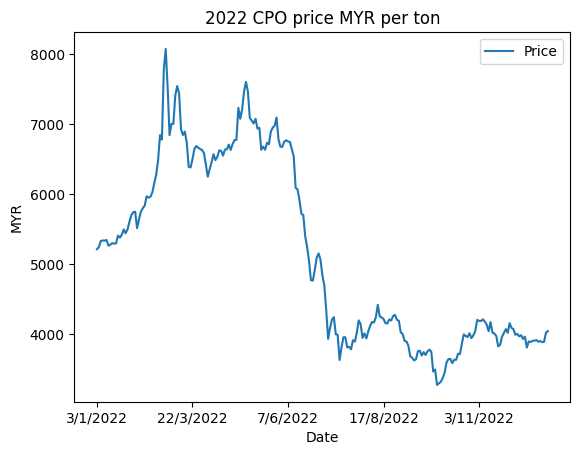

In [3]:
df.plot()
plt.title("2022 CPO price MYR per ton")
plt.ylabel("MYR")
plt.xlabel("Date")

In [4]:
df

,Price
Date,
3/1/2022,5214.0
4/1/2022,5245.5
5/1/2022,5331.0
6/1/2022,5340.0
7/1/2022,5336.0
...,...
21/12/2022,3901.5
22/12/2022,3886.5
23/12/2022,3890.5


# Initial EDA

In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
def adf_test(df):
    """Augmanted Dickey-Fuller test"""
    result = adfuller(df.Price.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(df)


ADF Statistic: -0.933500
p-value: 0.776740


Text(0.5, 1.0, 'Autocorrelation Original Series')

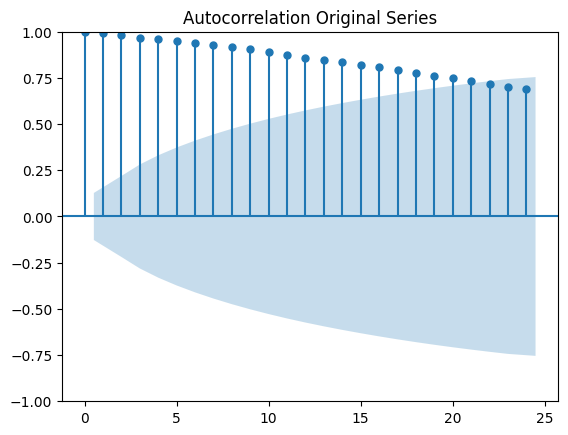

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.Price)
plt.title("Autocorrelation Original Series")

Text(0.5, 1.0, 'Partial Auto Original Series')

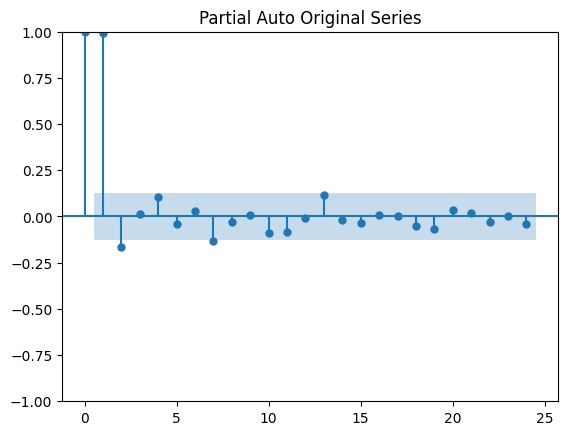

In [7]:
plot_pacf(df.Price)
plt.title("Partial Auto Original Series")

# Post initial

<Axes: xlabel='Date'>

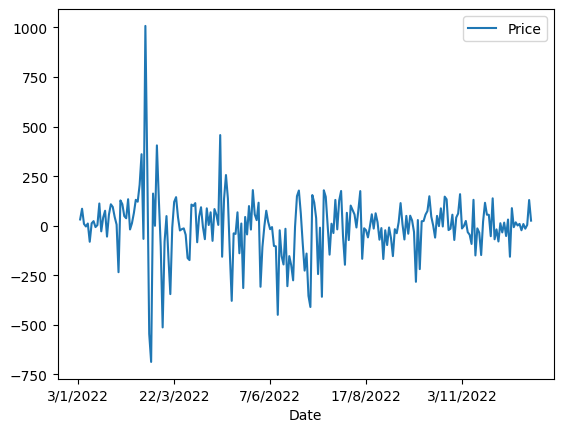

In [8]:
# 1st diff
df.diff().plot()

In [9]:
# stationarity
adf_test(df.diff())

ADF Statistic: -5.438952
p-value: 0.000003


Text(0.5, 1.0, 'Autocorrelation  Series Diff. lag=1')

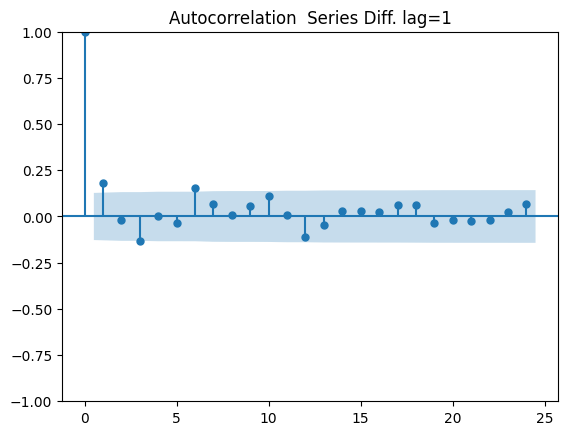

In [10]:
plot_acf(df.Price.diff().dropna())
plt.title("Autocorrelation  Series Diff. lag=1")

Text(0.5, 1.0, 'Partial Autocorrelation Diff. lag=1')

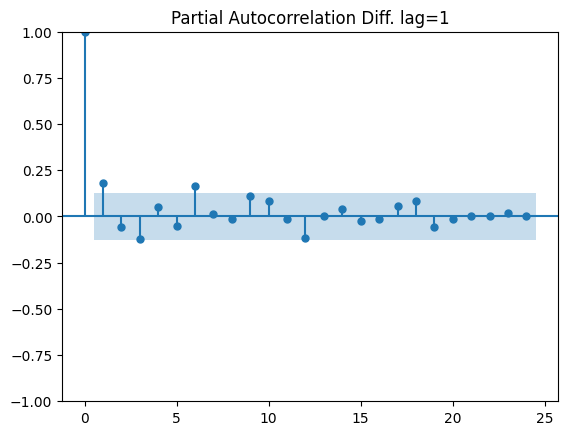

In [11]:
plot_pacf(df.Price.diff().dropna())
plt.title("Partial Autocorrelation Diff. lag=1")

Text(0.5, 1.0, 'Differencing lag 2')

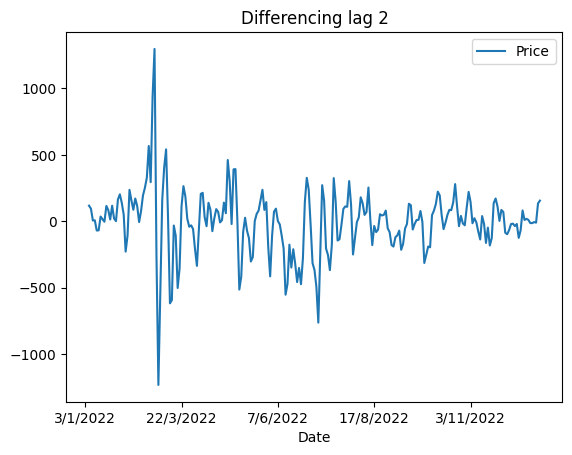

In [12]:
#2nd diff
df.diff(2).plot()
plt.title("Differencing lag 2")

In [13]:
adf_test(df.diff(2))

ADF Statistic: -3.456295
p-value: 0.009183


Text(0.5, 1.0, 'Autocorrelation Series Diff. lag=2')

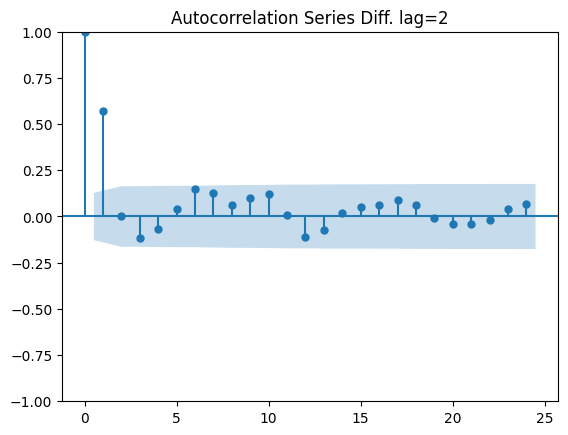

In [14]:
plot_acf(df.Price.diff(2).dropna())
plt.title("Autocorrelation Series Diff. lag=2")

Text(0.5, 1.0, 'Partial Autocorrelation Series Diff. lag=2')

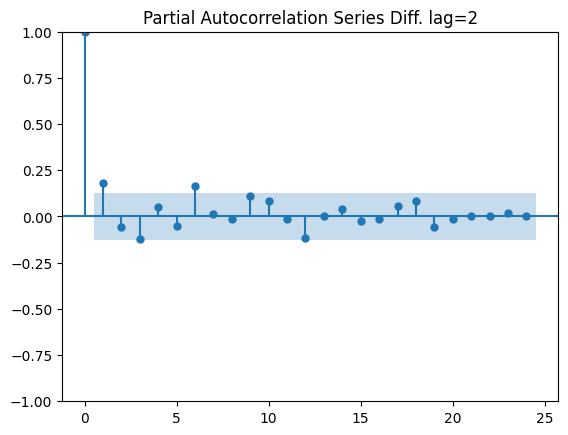

In [15]:
plot_pacf(df.Price.diff().dropna())
plt.title("Partial Autocorrelation Series Diff. lag=2")

# Modelling

In [16]:
from statsmodels.tsa.arima.model import ARIMA

# split
train = df.iloc[:-47,:]
test = df.iloc[-47:,:]
# 1,1,2 ARIMA Model
model = ARIMA(df.Price, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  237
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1522.003
Date:                Mon, 17 Jul 2023   AIC                           3050.007
Time:                        23:23:18   BIC                           3060.386
Sample:                             0   HQIC                          3054.191
                                - 237                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1900      0.044      4.308      0.000       0.104       0.276
ma.L1         -0.9996      0.310     -3.222      0.001      -1.608      -0.391
sigma2       2.41e+04   7360.340      3.275      0.0

In [17]:
pred = model_fit.predict(start=237+1, end=237+12)
pred

238    4043.724626
239    4039.677659
240    4035.465403
241    4031.221743
242    4026.972116
243    4022.721354
244    4018.470378
245    4014.219361
246    4009.968336
247    4005.717309
248    4001.466282
249    3997.215255
Name: predicted_mean, dtype: float64

<Axes: >

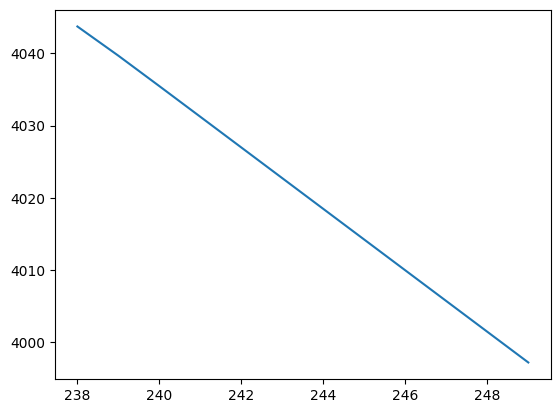

In [18]:
pred.plot()

# one step

In [19]:
#RMSE

from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    test_ = df_cp.iloc[size_:,:]
    train_ = df_cp.iloc[:size_,:]

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(1,2,1))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = np.sqrt(mean_squared_error(test_, pred)) #rmse
    return err
    
one_step_ahead(df, .8)

def loop_pct():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct()

,pct,res
0,0.80,435.652967
1,0.85,139.486735
2,0.90,80.177217
3,0.95,76.463799


In [20]:
# MAPE

from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
def one_step_ahead_mape(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    test_ = df_cp.iloc[size_:,:]
    train_ = df_cp.iloc[:size_,:]

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(1,2,1))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = mean_absolute_percentage_error(test_, pred) #mape
    return err
    
one_step_ahead_mape(df, .8)

def loop_pct_mape():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_mape(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_mape()

,pct,res
0,0.80,0.104199
1,0.85,0.029701
2,0.90,0.013994
3,0.95,0.016094


In [21]:
# pct change measurement

from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead_chg(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    test_ = df_cp.iloc[size_:,:]
    train_ = df_cp.iloc[:size_,:]
    pct_change_test_ = 100 * test_.pct_change().dropna()

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Price, order=(1,2,1))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    pred_pct_change = 100 * pred.pct_change().dropna()
    err = np.sqrt(mean_squared_error(pct_change_test_, pred_pct_change)) #rmse
    return err
    
one_step_ahead_chg(df, .8)

def loop_pct_chg():
    dict = {'pct':[], 'res':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['res'].append(one_step_ahead_chg(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_chg()

,pct,res
0,0.80,1.933673
1,0.85,1.811743
2,0.90,1.604801
3,0.95,1.328475


In [27]:
# RMSE within-sample & out-sample
from sklearn.metrics import mean_squared_error
import numpy as np
def one_step_ahead_train(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    test_ = df_cp.iloc[size_:,:]



    # pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    # err = np.sqrt(mean_squared_error(test_, pred)) #rmse

    # 1,2,1 ARIMA Model
    model = ARIMA(train_.Price, order=(3,2,1))
    model_fit = model.fit()
    # pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    # err = np.sqrt(mean_squared_error(test_, pred))
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    err = np.sqrt(mean_squared_error(test_, pred))

    pred_t = model_fit.predict(start= 0, end = len(train_)-1)
    err_t = np.sqrt(mean_squared_error(train_[2:], pred_t[2:]))

    # return pd.concat([err_t,err], axis= 1)
    return (err_t, err)
    
one_step_ahead_train(df, .8)

def loop_pct_train():
    dict = {'pct':[], '(train, test)':[]}
    _lst = [x / 100.0 for x in range(80, 100, 5 )]
    for _ in _lst:
        dict['(train, test)'].append(one_step_ahead_train(df, _))
        dict['pct'].append(_)
    return pd.DataFrame(dict)

loop_pct_train()

,pct,"(train, test)"
0,0.80,"(168.61560637354432, 493.8926572409505)"
1,0.85,"(165.09790026758577, 432.34862539126186)"
2,0.90,"(161.9623577187414, 82.11482298455795)"
3,0.95,"(158.23172456705538, 81.57301714737174)"


### Plotting results

,Train,test,predicted_mean
0,5214.0,NaN,NaN
1,5245.5,NaN,NaN
2,5331.0,NaN,NaN
3,5340.0,NaN,NaN
4,5336.0,NaN,NaN
...,...,...,...
233,NaN,3886.5,3447.396976
234,NaN,3890.5,3440.625483
235,NaN,4020.0,3433.853991
236,NaN,4045.5,3427.082499


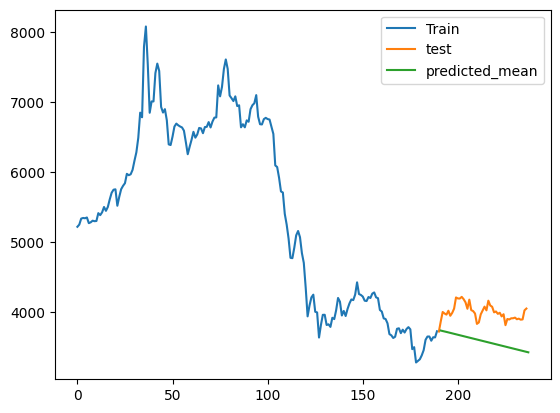

In [23]:
# ploting results
def plot_res(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    train_.rename(columns={'Price': 'Train'}, inplace=True)
    test_ = df_cp.iloc[size_:,:]
    test_.rename(columns={'Price': 'test'}, inplace=True)
    # pct_change_test_ = 100 * test_.pct_change().dropna()

    # 1,1,2 ARIMA Model
    model = ARIMA(train_.Train, order=(1,2,1))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))

    df_plot = pd.concat([train_, test_], axis= 1)
    df_plot.reset_index(inplace=True, drop=True)
    df_plot = pd.concat([df_plot, pred], axis= 1)
    # df_plot.rename(columns={'Price': 'Train', 'Price': 'Test', 'predicted_mean': 'Forecast'}, inplace=True)
    df_plot.plot()
    return df_plot


    
plot_res(df, .8)

,Train,Model Fit,Forecast,Test
2,5331.0,5358.117044,NaN,NaN
3,5340.0,5441.826865,NaN,NaN
4,5336.0,5427.959796,NaN,NaN
5,5347.0,5390.807525,NaN,NaN
6,5266.0,5406.066058,NaN,NaN
...,...,...,...,...
233,NaN,NaN,3371.336181,3901.5
234,NaN,NaN,3363.645310,3886.5
235,NaN,NaN,3355.954440,3890.5
236,NaN,NaN,3348.263570,4020.0


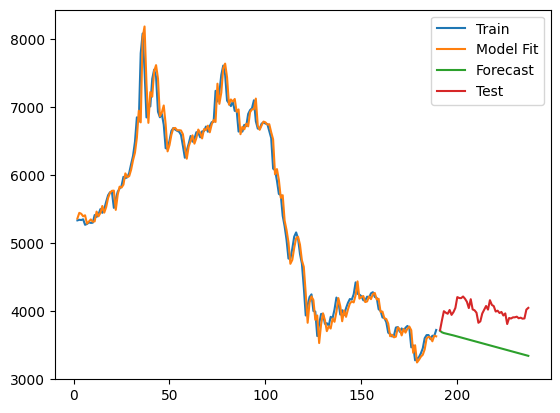

In [26]:
def plot_res_train(df_, split_):
    df_cp = df_
    size_ = round(len(df_cp)*split_)
    train_ = df_cp.iloc[:size_,:]
    train_.rename(columns={'Price': 'Train'}, inplace=True)
    test_ = df_cp.iloc[size_:,:]
    test_.rename(columns={'Price': 'test'}, inplace=True)
    # pct_change_test_ = 100 * test_.pct_change().dropna()

    # MA 2
    model = ARIMA(train_.Train, order=(3,2,1))
    model_fit = model.fit()
    pred = model_fit.predict(start=len(train_)+1, end=len(train_)+len(test_))
    pred_t = model_fit.predict(start= 0, end = len(train_)-1)

    df_plot = pd.concat([train_, pred_t], axis= 1)
    df_plot.reset_index(inplace=True, drop=True)
    df_plot = pd.concat([df_plot, pred], axis= 1)
    test_.set_index(keys = pred.index, inplace = True)
    df_plot = pd.concat([df_plot, test_], axis= 1)
    df_plot.columns = ['Train', 'Model Fit', 'Forecast', 'Test']
    
    df_plot.iloc[2:,:].plot()
    return df_plot.iloc[2:,:]

plot_res_train(df, .8)

In [25]:
from pmdarima import auto_arima
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(train, start_p = 1, start_q = 1,
                          max_p = 10, max_q = 10, m = 12,
                          start_P = 0, seasonal = False,
                          d = 2, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2563.180, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2539.287, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2561.180, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2531.128, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2512.526, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=2509.435, Time=0.11 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=2491.315, Time=0.12 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=2490.612, Time=0.15 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=2491.251, Time=0.19 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=2477.742, Time=0.30 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  190
Model:               SARIMAX(3, 2, 1)   Log Likelihood               -1231.625
Date:                Mon, 17 Jul 2023   AIC                           2473.250
Time:                        23:23:25   BIC                           2489.432
Sample:                             0   HQIC                          2479.806
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1794      0.072      2.478      0.013       0.037       0.321
ar.L2         -0.0592      0.045     -1.326      0.185      -0.147       0.028
ar.L3         -0.1432      0.056     -2.545      0.011      -0.253      -0.033
ma.L1         -0.9623      0.026    -36.691      0.000      -1.014      -0.911
sigma2      2.816e+04   1339.038     21.029      0.000    2.55e+04    3.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               475.80
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""